In [2]:
%matplotlib inline
import utils
import importlib
importlib.reload(utils)
from utils import *

In [3]:
import re, string, collections, pickle, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score

In [4]:
df = pd.read_csv('apple_reddit_merged.csv')

In [5]:
df.shape

(2693, 5)

The objective of this notebook is to train a sentiment analysis classifier given the games reviews in the dataset. The model must classify text reviews in positive or negative

In [5]:
df.head()

,text,Date,Open,Close,value
0,"No, Apple Does Not Help the NSA Hack iPhones",12/31/2013,73.398,74.303,1
1,Apple Denies Working With NSA On iPhone Backdoor,12/31/2013,73.398,74.303,1
2,A new operating system tool for the iPhone – “...,1/2/2014,73.596,73.259,-1
3,Apple negirao kontakte sa američkim tajnim slu...,1/2/2014,73.596,73.259,-1
4,"NSA Backdoor in Apple Iphone , Ipad and other ...",1/2/2014,73.596,73.259,-1


Let's keep just text and score columns

In [5]:
df = df[['text', 'value']]

In [7]:
df.head()

,text,value
0,"No, Apple Does Not Help the NSA Hack iPhones",1
1,Apple Denies Working With NSA On iPhone Backdoor,1
2,A new operating system tool for the iPhone – “...,-1
3,Apple negirao kontakte sa američkim tajnim slu...,-1
4,"NSA Backdoor in Apple Iphone , Ipad and other ...",-1


In [8]:
print(f'positive headlines: {len(df.loc[df["value"] == 1])}')
print(f'negative headlines: {len(df.loc[df["value"] == -1])}')

positive headlines: 1350
negative headlines: 1343


In [6]:
pos = df.loc[df['value'] == 1, 'text'].copy().reset_index(drop=True)
neg = df.loc[df['value'] == -1, 'text'].copy().reset_index(drop=True)

In [10]:
len(pos), len(neg)

(1350, 1343)

Let's print some positive reviews examples

In [11]:
for i in range(4):
    print(''.join(pos[np.random.randint(0, len(pos))]))
    print('\n')

The Only Way Apple Can Save iTunes Is To Bring It To The Web


Apple to remove headphone jack from next iPhone


Apple Introduces New iPad Smart Case


BBC - Apple unveils Watch and new iPhones




Let's print some negative reviews examples

In [12]:
for i in range(4):
    print(''.join(neg[np.random.randint(0, len(neg))]))
    print('\n')

Apple iPhone 6s Plus vs LG G4


Spotify vs Apple Music


Impervious Apple iPhone 6 Waterproofing Kits


Why you pay big bucks for Apple




We must add the labels: 0 for negative reviews, 1 for positive reviews

In [7]:
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns=['class'])], 1)
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(pos.shape), columns=['class'])], 1)

Mean, standard deviation and max length of negative reviews

In [14]:
pos.head()

,text,class
0,"No, Apple Does Not Help the NSA Hack iPhones",1.0
1,Apple Denies Working With NSA On iPhone Backdoor,1.0
2,A Little Guy Sticks It to Apple and Jamie Dimon,1.0
3,Apple's new Retail Chief 'may' hint at the com...,1.0
4,"Apple, Amazon downgraded 'on moral and ethical...",1.0


Is desirable to have a balanced dataset (similar quantity of positive and negative instances). So we will pick a random subset of the positive instances.

In [8]:
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)

In [9]:
neg.shape, pos.shape

((1343, 2), (1343, 2))

We concatenate positive and negative reviews

In [10]:
df = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
df.head()

,text,class
0,Apple stock Down due to iOS Problems and this ...,0.0
1,Apple Is Considering Renaming Beats Music,0.0
2,Apple Stock Robot Review SCAM OR LEGIT?,0.0
3,Samsung ordered to pay Apple $119.6 million in...,1.0
4,Apple negirao kontakte sa američkim tajnim slu...,0.0


In [13]:
df.shape

(2686, 2)

Split data into train and test set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['class'].values, test_size=0.2, random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2148, 538, 2148, 538)

Defining tokenizer

In [12]:
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "s", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

Creating bag of words

In [13]:
vect = CountVectorizer(strip_accents='unicode', stop_words=ENGLISH_STOP_WORDS, binary=True)

In [14]:
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

Train term frequency contains 32675 documents and 45424 tokens. Each row represents a document and each column how many times that token appears on the document.

In [23]:
tf_train

<2148x4738 sparse matrix of type '<class 'numpy.int64'>'
	with 16619 stored elements in Compressed Sparse Row format>

For instance, the first document have just 65 of the 45424 possible tokens. That's why the matrix is stored as a sparse matrix.

In [24]:
tf_train[0]

<1x4738 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

Get vocabulary

In [15]:
vocab = vect.get_feature_names()
len(vocab)

4738

In [26]:
vocab[4000: 4005]

['stunning', 'stupid', 'style', 'styled', 'stylish']

In [27]:
X_train[1]

'Apple Launches Comprehensive New Siri Website With Categories, Example Requests'

First review's tokens

In [28]:
w0 = set([o for o in X_train[2].split(' ')])

In [29]:
w0

{'Apple',
 'Big',
 'Coast,',
 'Duff',
 'Goodbye',
 'Hello',
 'Hilary',
 'Says',
 'West'}

In [100]:
vect.vocabulary_

{'steve': 3959,
 'jobs': 2297,
 'memorial': 2644,
 'russia': 3593,
 'torn': 4255,
 'apple': 412,
 'ceo': 828,
 'tim': 4227,
 'cook': 1077,
 'came': 768,
 'gay': 1818,
 'launches': 2412,
 'comprehensive': 1013,
 'new': 2810,
 'siri': 3792,
 'website': 4548,
 'categories': 803,
 'example': 1577,
 'requests': 3473,
 'hilary': 1996,
 'duff': 1430,
 'says': 3632,
 'goodbye': 1866,
 'west': 4557,
 'coast': 944,
 'hello': 1979,
 'big': 609,
 'patents': 3013,
 'tech': 4139,
 'checks': 867,
 'bank': 537,
 'account': 244,
 'target': 4116,
 'ads': 291,
 'watch': 4526,
 'sales': 3608,
 'drop': 1416,
 '90': 207,
 'percent': 3048,
 'opening': 2919,
 'week': 4550,
 'create': 1122,
 'id': 2085,
 'using': 4430,
 'credit': 1127,
 'card': 788,
 'impervious': 2115,
 'iphone': 2235,
 'waterproofing': 4532,
 'kits': 2360,
 'til': 4226,
 'cia': 900,
 'tried': 4302,
 'years': 4633,
 'break': 695,
 'gear': 1821,
 'phone6': 3066,
 '6s': 183,
 '5s': 166,
 '5c': 160,
 'usbケーフルgshine': 4421,
 'mfi': 2661,
 'ipod':

In [37]:
tf_train[0, 1416]

0

### Multinomial Naive Bayes

Here we reduce our training data to 2 dimentions (using TruncatedSVD rather than PCA because we are working with sparse matrices) and then we plot it in order to  roughly see how classes are separated

In [16]:
svd = TruncatedSVD()
reduced_tf_train = svd.fit_transform(tf_train)

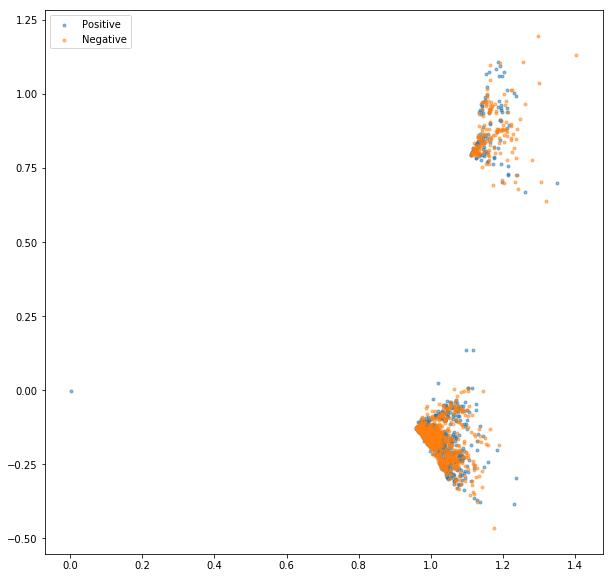

In [17]:
plot_embeddings(reduced_tf_train, y_train)

Use Grid Search to find hyper parametes

In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [20]:
np.random.seed(1)

pipeline_svm = make_pipeline(vect, SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.5s finished


0.5617562917202206

In [25]:
grid_svm.best_params_

{'svc__C': 1}

In [22]:
grid_svm.best_score_

0.5998182303592605

In [26]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [27]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.5464684014869888,
 'auc': 0.5617010102685296,
 'f1': 0.5673758865248226,
 'precision': 0.5460750853242321,
 'recall': 0.5904059040590406}

See how Logistic Regression performs

In [74]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.5743494423791822


F:\Documents\CPSC 571 Project\venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


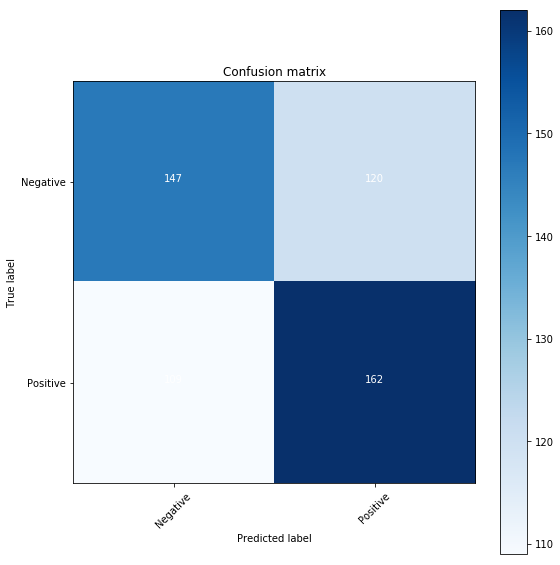

In [105]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

Let's plot most relevant words that the algorithm uses to classify a text in positive or negative

In [56]:
coef_df = pd.DataFrame({'vocab': vocab, 'coef':model.coef_.reshape(-1)})
pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

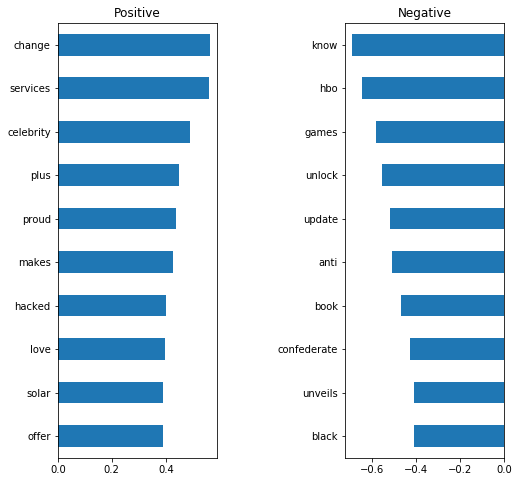

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');

Removing word from vocabulary

In [108]:
vect.vocabulary_['bethehouse']

KeyError: 'bethehouse'

In [48]:
tf_train = lil2(tf_train)
tf_train.removecol(2052)

In [49]:
tf_test = lil2(tf_test)
tf_test.removecol(2052)

In [109]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.5743494423791822


F:\Documents\CPSC 571 Project\venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Let's try now with bigram tf-idf rather than unigram tf

In [64]:
vect = TfidfVectorizer(strip_accents='unicode', stop_words=ENGLISH_STOP_WORDS, binary=True, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)

In [65]:
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

Division between classes is more clear now

In [66]:
svd = TruncatedSVD()
reduced_tfidf_train = svd.fit_transform(tfidf_train)

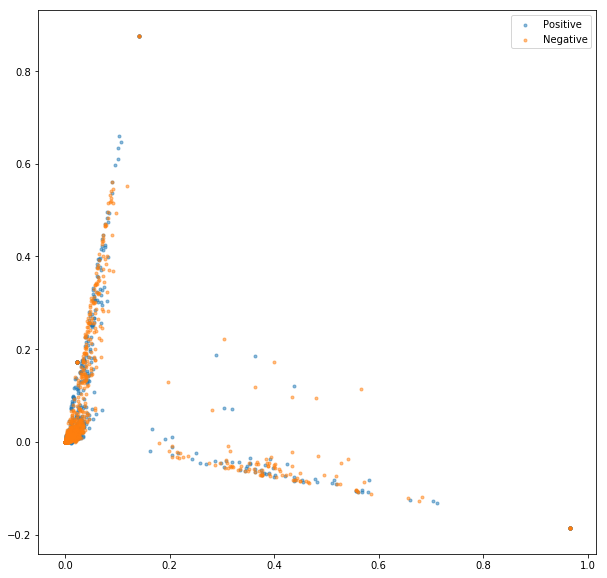

In [67]:
plot_embeddings(reduced_tfidf_train, y_train, 2000)

In [115]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()

nb.fit(tfidf_train, y_train)

nb.score(tfidf_train, y_train)

0.7686219739292365

In [117]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
y_pred = nb.predict(tfidf_test)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 57.62%

F1 Score: 59.14

COnfusion Matrix:
 [[145 122]
 [106 165]]


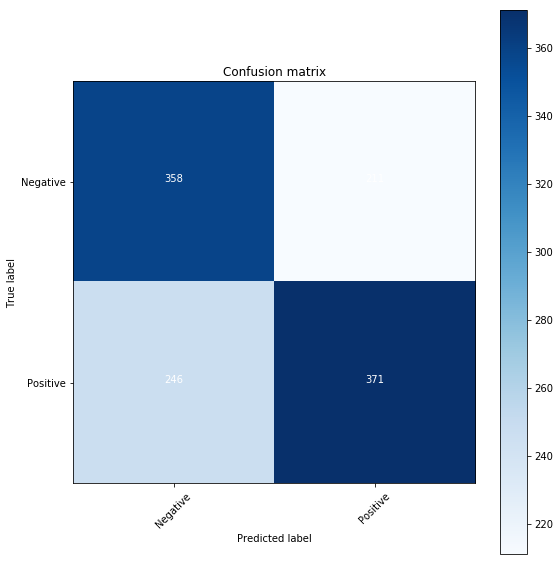

In [69]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

### SVM

### CNN

We will try now with a simple Convolutional Neural Network

In [118]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input, concatenate
from keras.optimizers import Adam

Tokenize reviews

In [119]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [123]:
df['tokenized'] = df['text'].apply(tokenize)

Get vocabulary

In [124]:
def update_vocab_counter(row):
    for word in row:
        vocab_counter[word] += 1

In [125]:
vocab_counter = collections.Counter()
df['tokenized'].apply(update_vocab_counter);
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)

In [126]:
len(vocab)

7295

Word to index dictionary

In [127]:
w2id = {w:i for i, w in enumerate(vocab)}

Words to index transformation

In [128]:
def transform_to_ids(row):
    return [w2id[w] for w in row]

In [129]:
df['tokenized'] = df['tokenized'].apply(lambda x: transform_to_ids(x))

In [130]:
X_train, X_test, y_train, y_test = train_test_split(df['tokenized'].values, df['class'].values, test_size=0.2, random_state=42)

In [131]:
maxlen = 1000

All the inputs to the conv net must have a fixed size. We set 1000 as the max length and we fill with -1 all reviews smaller than 1000.

In [132]:
x_train = pad_sequences(X_train, maxlen=maxlen, value=-1)
x_test = pad_sequences(X_test, maxlen=maxlen, value=-1)

In [133]:
model = Sequential([Embedding(input_dim=len(vocab), output_dim=32, input_length=maxlen),
                    SpatialDropout1D(0.2),
                    Dropout(0.25),
                    Convolution1D(64, 5, padding='same', activation='relu'),
                    Dropout(0.25),
                    MaxPooling1D(),
                    Flatten(),
                    Dense(100, activation='relu'),
                    Dropout(0.85),
                    Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [134]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=4, batch_size=64)

Train on 2148 samples, validate on 538 samples
Epoch 1/4
2148/2148 [==============================] - 8s 4ms/step - loss: 0.6938 - acc: 0.4972 - val_loss: 0.6932 - val_acc: 0.4981
Epoch 2/4
2148/2148 [==============================] - 1s 324us/step - loss: 0.6942 - acc: 0.4902 - val_loss: 0.6931 - val_acc: 0.5074
Epoch 3/4
2148/2148 [==============================] - 1s 315us/step - loss: 0.6913 - acc: 0.5335 - val_loss: 0.6932 - val_acc: 0.5093
Epoch 4/4
2148/2148 [==============================] - 1s 313us/step - loss: 0.6871 - acc: 0.5512 - val_loss: 0.6919 - val_acc: 0.5019


Maybe finding best hyperparameters could lead to a better accuracy, but this more complex model is not better than our linear classifier.